In [1]:
import tensorflow as tf
import keras
import numpy as np
import math

Using TensorFlow backend.


In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [4]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

<Figure size 640x480 with 2 Axes>

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

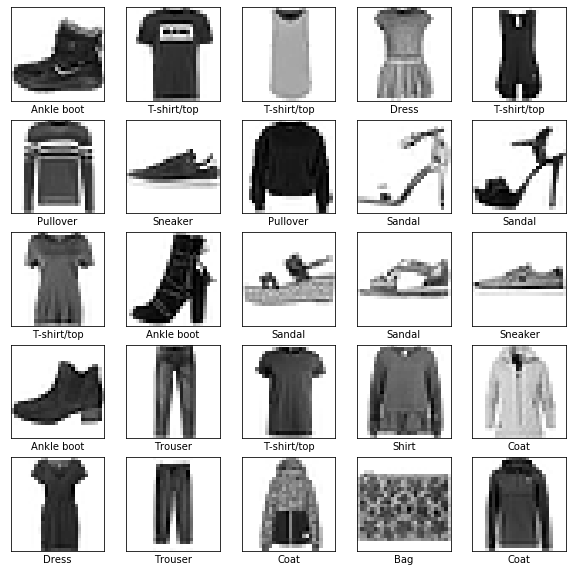

In [6]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

In [7]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(10, activation='softmax')
])

# model = tf.keras.Sequential()
# # Must define the input shape in the first layer of the neural networ
# model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
# model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
# model.add(tf.keras.layers.Dropout(0.3))
# model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
# model.add(tf.keras.layers.Dropout(0.3))
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(256, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(10, activation='softmax'))
# # Take a look at the model summary
# model.summary()

In [8]:
def getSecret(image):
    return np.unpackbits(np.array(image.flatten(), np.uint8))

In [9]:
def bin2str(bs):
    secret_string = ''.join(str(x) for x in bs)
    return secret_string

def bitToLabel(bits, label_num):
    x = math.ceil(len(bits)/label_num)
    label = [0]*x
    for i in range(x):
        label[i] = int(bits[i*label_num:(i+1)*label_num], 2)
    return label

def labelToBit(label, label_num):
    strv = ""
    for l in label:
        temp = bin(l).replace('0b','')
#         strv += temp
        pad = label_num - len(temp)
        strv += pad * "0" + temp
    return strv

def str2bin(strv):
    return np.array([int(c) for c in strv])

In [34]:
def getPrimeList(len):   
    list=[]
    i=2
    for i in range (2,len):
        j=2
        for j in range(2,i):
            if(i%j==0):
                break
        else:
            list.append(i)
    return list


def genMal(length, shape = (28, 28), force = 10):
    mal_x = np.zeros((length, shape[0], shape[1]))
    p_list = getPrimeList(force)
    for i in range(length):
        round = int((i / (28 * 28)) + 1)
#         print(int(i/28) - round + 1)
#         mal_x[i, int((i%(28*28))/28) - round + 1, i%28] = round * 3;
#         mal_x[i, int(((i+3)%(28*28))/28) - round + 1, (i+3)%28] = round * 5;
#         mal_x[i, int(((i+5)%(28*28))/28) - round + 1, (i+5)%28] = round * 7;
#         mal_x[i, int(((i+11)%(28*28))/28) - round + 1, (i+11)%28] = round * 11;
#         mal_x[i, int(((i+13)%(28*28))/28) - round + 1, (i+13)%28] = round * 13;
#         mal_x[i, int(((i+17)%(28*28))/28) - round + 1, (i+17)%28] = round * 17;
        for p in p_list:
            mal_x[i, int(((i + p)%(28*28))/28) - round + 1, (i+p) % 28] = round * p
        
    return mal_x

def duplicate(x_mal, y_mal, d = 10):
    x = x_mal
    y = y_mal
    for i in range(d):
        x_mal = np.vstack((x, x_mal))
        y_mal = np.hstack((y, y_mal))
    return x_mal, y_mal

def augumentAttack(x_train, y_train, start = 0, size = 1, force = 10, d = 10):
    secret_image = x_train[start:start+size]
    showImg(secret_image)
    secret_image_int = img_as_ubyte(secret_image)
    s = getSecret(secret_image_int)

    max_bit_size = math.floor(math.log(len(class_names), 2))
    transformed_s = bitToLabel(bin2str(s), max_bit_size)

    x_mal = genMal(len(transformed_s), force = force)
    y_mal = np.array(transformed_s)
    
    d_x_mal, d_y_mal = duplicate(x_mal, y_mal, d)
    x_new = np.vstack((x_train, d_x_mal))

    y_new = np.hstack((y_train, d_y_mal))
    
    secret_lenght = len(transformed_s)
    
    return x_new, y_new, secret_lenght

In [11]:
from skimage import img_as_ubyte
def showImg(img):
    plt.figure()
    if(len(img.shape) > 2):
        for i in range(img.shape[0]):
            I = img[i]
            plt.subplot(1,img.shape[0]+1,i+1)
            plt.imshow(I)
    else:
        plt.imshow(img)
    plt.grid(False)
    plt.show()

In [12]:
def decode(s, shape = (28, 28)):
    # convert binary to decimals
    decimals = np.packbits(s);
    print(decimals.shape)
    return decimals.reshape((-1, shape[0], shape[1]))

## attack begins at here

secret_num indicate the number of image you want to steal

In [102]:
def attack(start = 2, size = 1, force = 10, d = 10):
    secret_num = size
    x_new, y_new, secret_length = augumentAttack(x_train, y_train, start, secret_num, force, d)
    
    test_model = keras.Sequential([
        keras.layers.Flatten(input_shape=(28, 28)),
        keras.layers.Dense(128, activation = 'relu'),
        keras.layers.Dense(20, activation='softmax')
    ])

    test_model.compile(
        optimizer = 'adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    test_model.fit(x_new,
             y_new,
             batch_size=128,
             epochs=20)
    
    x_mal = genMal(secret_length,force = force)
    max_bit_size = math.floor(math.log(len(class_names), 2))
    y_pred = np.argmax(test_model.predict(x_mal), axis = 1)

    print(len(y_pred))

    strv = labelToBit(y_pred, max_bit_size)[:secret_num*6272]

    print(len(strv))
    test_s = str2bin(strv)
    ds = decode(test_s)
    showImg(ds)
    img_by_d[d] = ds

    test_loss, test_acc = test_model.evaluate(x_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)
    return test_acc

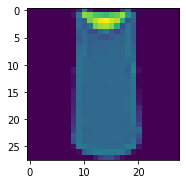

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
83001/83001 [==============================] - 3s 37us/step - loss: 0.7567 - acc: 0.7629: 2s - los - ETA: 0s - loss: 0.7724 - acc: 0.759 - ETA: 0s - loss: 0.7653 - acc: 0.76
Epoch 2/20
83001/83001 [==============================] - 2s 29us/step - loss: 0.4594 - acc: 0.8350: 2s - loss: 0.5107 - acc:  - ETA: 1s - lo - ETA: 0s - loss: 0.4674 - acc: 0.832 - ETA: 0s - loss: 0.4664 - acc:
Epoch 3/20
83001/83001 [==============================] - 2s 29us/step - loss: 0.3858 - acc: 0.8540: 1s - loss:
Epoch 4/20
83001/83001 [==============================] - 2s 27us/step - loss: 0.3449 - acc: 0.8668: 1s - l
Epoch 5/20
83001/83001 [==============================] - 2s 29us/step - loss: 0.3114 - acc: 0.8836
Epoch 6/20
83001/83001 [==============================] - 2s 29us/step - loss: 0.2886 - acc: 0.8970: 1s - loss: 0.2891 - acc: 0.896 - ETA: 0s - loss: 0.2895 - ETA: 0s - loss: 0.2890 - acc: 0.89 - ETA: 0s - loss: 0.2885 - acc: 0.897
Epoch 7/20
83001/83001 [===========================

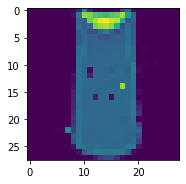


Test accuracy: 0.8875


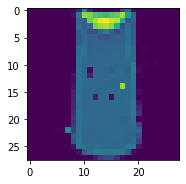

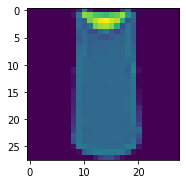

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
83001/83001 [==============================] - 3s 38us/step - loss: 0.7390 - acc: 0.7646
Epoch 2/20
83001/83001 [==============================] - 2s 30us/step - loss: 0.4659 - acc: 0.8315
Epoch 3/20
83001/83001 [==============================] - 3s 31us/step - loss: 0.4014 - acc: 0.8473: 0s - loss: 0.4011 - acc:
Epoch 4/20
83001/83001 [==============================] - 3s 31us/step - loss: 0.3629 - acc: 0.8597
Epoch 5/20
83001/83001 [==============================] - 2s 30us/step - loss: 0.3326 - acc: 0.8716
Epoch 6/20
83001/83001 [==============================] - 3s 36us/step - loss: 0.3087 - acc: 0.8815
Epoch 7/20
83001/83001 [==============================] - 3s 35us/step - loss: 0.2889 - acc: 0.8938
Epoch 8/20
83001/83001 [==============================] - 3s 31us/step - loss: 0.2694 - acc: 0.9021
Epoch 9/20
83001/83001 [==============================] - 2s 29us/step - loss: 0.2557 - acc: 0.9077
Epoch 10/20
83001/83001 [==============================] - 2s 29us/step - 

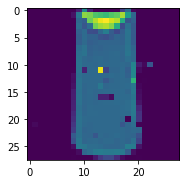


Test accuracy: 0.8814


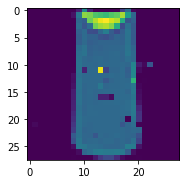

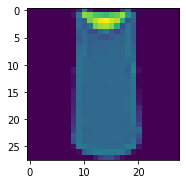

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
83001/83001 [==============================] - 3s 38us/step - loss: 0.7420 - acc: 0.7640
Epoch 2/20
83001/83001 [==============================] - 2s 28us/step - loss: 0.4692 - acc: 0.8304: 0s - loss: 0.4813 -
Epoch 3/20
83001/83001 [==============================] - 3s 34us/step - loss: 0.4010 - acc: 0.8473
Epoch 4/20
83001/83001 [==============================] - 3s 31us/step - loss: 0.3599 - acc: 0.8595: 1s - loss: 0.3663 -  - ETA: 0s - loss: 0.3639 - a
Epoch 5/20
83001/83001 [==============================] - 3s 33us/step - loss: 0.3329 - acc: 0.8714: 0s - loss: 0.3339 - acc: 0.8
Epoch 6/20
83001/83001 [==============================] - 3s 32us/step - loss: 0.3055 - acc: 0.8838: 0s - loss: 0.3056 - acc: 0.883
Epoch 7/20
83001/83001 [==============================] - 3s 32us/step - loss: 0.2849 - acc: 0.8938
Epoch 8/20
83001/83001 [==============================] - 2s 29us/step - loss: 0.2676 - acc: 0.9023: 0s - loss: 0.266
Epoch 9/20
83001/83001 [========================

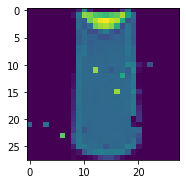


Test accuracy: 0.8817


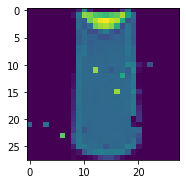

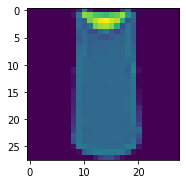

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
83001/83001 [==============================] - 3s 40us/step - loss: 0.6891 - acc: 0.7743: 5s - lo - ETA: 1s - loss: 0.7624 - acc: 0.7 - ETA: 0s - loss: 0.7454 - a
Epoch 2/20
83001/83001 [==============================] - 2s 28us/step - loss: 0.4574 - acc: 0.8257
Epoch 3/20
83001/83001 [==============================] - 2s 28us/step - loss: 0.4101 - acc: 0.8387
Epoch 4/20
83001/83001 [==============================] - 2s 28us/step - loss: 0.3761 - acc: 0.8504
Epoch 5/20
83001/83001 [==============================] - 2s 28us/step - loss: 0.3514 - acc: 0.8581
Epoch 6/20
83001/83001 [==============================] - 2s 28us/step - loss: 0.3298 - acc: 0.8682
Epoch 7/20
83001/83001 [==============================] - 2s 30us/step - loss: 0.3096 - acc: 0.8779
Epoch 8/20
83001/83001 [==============================] - 2s 28us/step - loss: 0.2899 - acc: 0.8905
Epoch 9/20
83001/83001 [==============================] - 2s 28us/step - loss: 0.2730 - acc: 0.8985
Epoch 10/20
83001/83001 [=

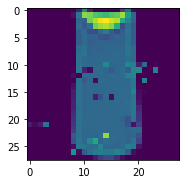


Test accuracy: 0.8828


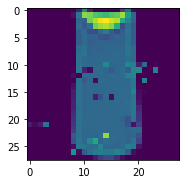

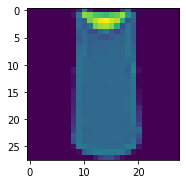

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
83001/83001 [==============================] - 3s 38us/step - loss: 0.6926 - acc: 0.7729
Epoch 2/20
83001/83001 [==============================] - 3s 30us/step - loss: 0.4574 - acc: 0.8276
Epoch 3/20
83001/83001 [==============================] - 3s 32us/step - loss: 0.4096 - acc: 0.8411
Epoch 4/20
83001/83001 [==============================] - 2s 30us/step - loss: 0.3739 - acc: 0.8513
Epoch 5/20
83001/83001 [==============================] - 2s 28us/step - loss: 0.3501 - acc: 0.8597
Epoch 6/20
83001/83001 [==============================] - 2s 29us/step - loss: 0.3239 - acc: 0.8721
Epoch 7/20
83001/83001 [==============================] - 2s 30us/step - loss: 0.3078 - acc: 0.8801: 1s - lo
Epoch 8/20
83001/83001 [==============================] - 2s 29us/step - loss: 0.2873 - acc: 0.8907: 0s - loss: 0.2882 - acc: 0.
Epoch 9/20
83001/83001 [==============================] - 2s 30us/step - loss: 0.2677 - acc: 0.8999: 1s - loss
Epoch 10/20
83001/83001 [==========================

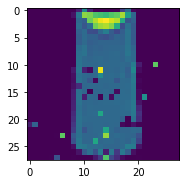


Test accuracy: 0.8857


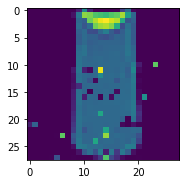

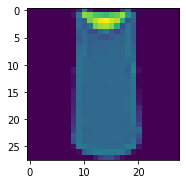

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
83001/83001 [==============================] - 3s 38us/step - loss: 0.6736 - acc: 0.7699: 0s - loss: 0.6743 - acc: 0.769
Epoch 2/20
83001/83001 [==============================] - 2s 29us/step - loss: 0.4670 - acc: 0.8172
Epoch 3/20
83001/83001 [==============================] - 2s 29us/step - loss: 0.4290 - acc: 0.8294
Epoch 4/20
83001/83001 [==============================] - 2s 29us/step - loss: 0.4000 - acc: 0.8393: 1s - l
Epoch 5/20
83001/83001 [==============================] - 2s 29us/step - loss: 0.3779 - acc: 0.8480
Epoch 6/20
83001/83001 [==============================] - 3s 32us/step - loss: 0.3592 - acc: 0.8550: 2s - loss: 0.3608  - ETA: 1s - loss: 0.3 - ETA: 0s - loss: 0.3605 - acc: 0.85 - ETA: 0s - loss: 0.3598 - 
Epoch 7/20
83001/83001 [==============================] - 3s 33us/step - loss: 0.3392 - acc: 0.8626: 0s - loss: 0.3419 
Epoch 8/20
83001/83001 [==============================] - 2s 29us/step - loss: 0.3240 - acc: 0.8703
Epoch 9/20
83001/83001 [=========

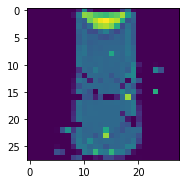


Test accuracy: 0.8809


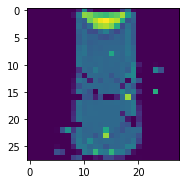

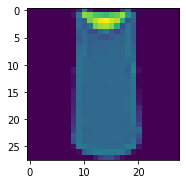

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
83001/83001 [==============================] - 3s 37us/step - loss: 0.6740 - acc: 0.7694
Epoch 2/20
83001/83001 [==============================] - 3s 32us/step - loss: 0.4650 - acc: 0.8169ETA: 0s - loss: 0.4649 - acc: 0.817
Epoch 3/20
83001/83001 [==============================] - 3s 31us/step - loss: 0.4221 - acc: 0.8321: 0s - loss: 0.4269 -
Epoch 4/20
83001/83001 [==============================] - 3s 30us/step - loss: 0.3948 - acc: 0.8417: 1s - loss: 0.3974 - acc: 0.84 - ETA: 1s - los
Epoch 5/20
83001/83001 [==============================] - 2s 30us/step - loss: 0.3715 - acc: 0.8514
Epoch 6/20
83001/83001 [==============================] - 3s 30us/step - loss: 0.3502 - acc: 0.8582
Epoch 7/20
83001/83001 [==============================] - 3s 30us/step - loss: 0.3312 - acc: 0.8665: 1s - loss: 0.3360 - acc - ETA: 0s - loss: 0.3
Epoch 8/20
83001/83001 [==============================] - 2s 29us/step - loss: 0.3163 - acc: 0.8744
Epoch 9/20
83001/83001 [==========================

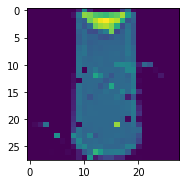


Test accuracy: 0.8832


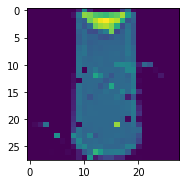

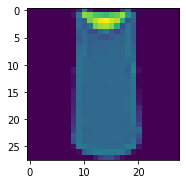

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
83001/83001 [==============================] - 3s 39us/step - loss: 0.6705 - acc: 0.7707: 0s - loss: 0.6905 - acc: 
Epoch 2/20
83001/83001 [==============================] - 3s 32us/step - loss: 0.4629 - acc: 0.8193A: 3s - loss: 0.4594 - acc - ETA: 2s - loss: 0.4819 - acc: 0. - ETA: 
Epoch 3/20
83001/83001 [==============================] - 2s 30us/step - loss: 0.4189 - acc: 0.8333: 1s 
Epoch 4/20
83001/83001 [==============================] - 3s 30us/step - loss: 0.3892 - acc: 0.8431: 1s - loss: 0.3931 - acc: 0.841 - ETA: 1s - loss: 0.39 - ETA: 0s - loss: 0.3913 - ac - ETA: 0s - loss: 0.3888 - acc: 0
Epoch 5/20
83001/83001 [==============================] - 2s 27us/step - loss: 0.3660 - acc: 0.8525
Epoch 6/20
83001/83001 [==============================] - 2s 29us/step - loss: 0.3472 - acc: 0.8594: 0s - loss: 0.3487 - ac
Epoch 7/20
83001/83001 [==============================] - 3s 31us/step - loss: 0.3293 - acc: 0.8674
Epoch 8/20
83001/83001 [==============================] 

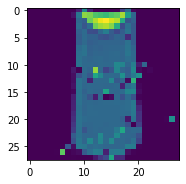


Test accuracy: 0.8848


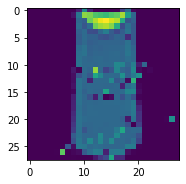

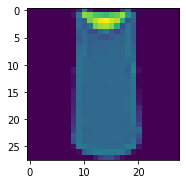

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
83001/83001 [==============================] - 3s 39us/step - loss: 0.6749 - acc: 0.7688: 0s - loss: 0.7100 - ac
Epoch 2/20
83001/83001 [==============================] - 2s 28us/step - loss: 0.4673 - acc: 0.8176
Epoch 3/20
83001/83001 [==============================] - 2s 27us/step - loss: 0.4236 - acc: 0.8318: 2s - loss: 0.4270 - acc: 0 - ETA: 1s - - ETA: 0s - loss: 0.4255 - acc: 0.
Epoch 4/20
83001/83001 [==============================] - 2s 28us/step - loss: 0.3930 - acc: 0.8429: 1s 
Epoch 5/20
83001/83001 [==============================] - 2s 28us/step - loss: 0.3730 - acc: 0.8501: 1s - loss: 0.3838 - acc:  - ETA: 1s - loss: 0.
Epoch 6/20
83001/83001 [==============================] - 2s 27us/step - loss: 0.3527 - acc: 0.8583: 1 - ETA: 0s - loss: 0.3529 - acc: 0.858
Epoch 7/20
83001/83001 [==============================] - 2s 28us/step - loss: 0.3345 - acc: 0.8651
Epoch 8/20
83001/83001 [==============================] - 2s 28us/step - loss: 0.3179 - acc: 0.8736: 2s - l

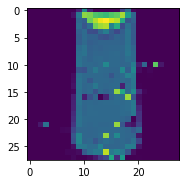


Test accuracy: 0.8847


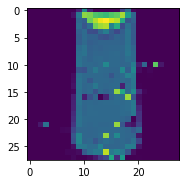

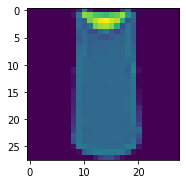

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
83001/83001 [==============================] - 3s 38us/step - loss: 0.6875 - acc: 0.7608: 0s - loss: 0.7125 - acc: 0
Epoch 2/20
83001/83001 [==============================] - 2s 29us/step - loss: 0.4804 - acc: 0.8090: 1s -
Epoch 3/20
83001/83001 [==============================] - 2s 28us/step - loss: 0.4437 - acc: 0.8203
Epoch 4/20
83001/83001 [==============================] - 2s 29us/step - loss: 0.4189 - acc: 0.8283: 2s - loss: 0.4261 - acc: 0. - ETA: 2s - loss: 0.4221 - a - ETA: 1s - loss:
Epoch 5/20
83001/83001 [==============================] - 2s 29us/step - loss: 0.3995 - acc: 0.8358: 0s - loss: 0.400
Epoch 6/20
83001/83001 [==============================] - 2s 29us/step - loss: 0.3808 - acc: 0.8447: 2s - loss: 0.3676 - acc: 0.84 - ETA: 2s - loss: 0.35 - ETA: 1s - loss: 0.3817 - acc:  - ETA: 0s - loss: 0.38
Epoch 7/20
83001/83001 [==============================] - 2s 29us/step - loss: 0.3656 - acc: 0.8504
Epoch 8/20
83001/83001 [==============================] - 2s 2

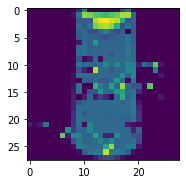


Test accuracy: 0.8793


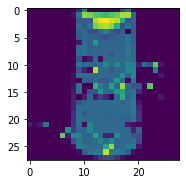

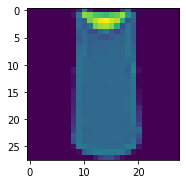

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
83001/83001 [==============================] - 4s 43us/step - loss: 0.6792 - acc: 0.7624: 0s - loss: 0.7106 - ac
Epoch 2/20
83001/83001 [==============================] - 3s 33us/step - loss: 0.4800 - acc: 0.8096: 1s - loss: 0.4887 - ac - ETA: 0s - loss: 0.4831 - 
Epoch 3/20
83001/83001 [==============================] - 3s 32us/step - loss: 0.4412 - acc: 0.8220: 2s - loss: 0. - ETA: 1s - loss: 0.44 - ETA: 0s - loss: 0.4420 - acc: 0.
Epoch 4/20
83001/83001 [==============================] - 3s 34us/step - loss: 0.4155 - acc: 0.8315: 2s - loss: 0.4054 - ac - ETA: 1s
Epoch 5/20
83001/83001 [==============================] - 3s 34us/step - loss: 0.3940 - acc: 0.8390: 0s - loss: 0.3932 -  - ETA: 0s - loss: 0.3946 - acc: 0. - ETA: 0s - loss: 0.3937 - acc: 0.839
Epoch 6/20
83001/83001 [==============================] - 3s 32us/step - loss: 0.3784 - acc: 0.8446: 1s - l - ETA: 0s - loss: 0.3789 - acc: 0.
Epoch 7/20
83001/83001 [==============================] - 3s 31us/step - loss: 

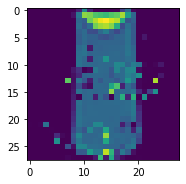


Test accuracy: 0.8774


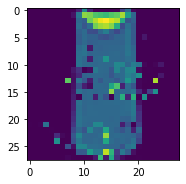

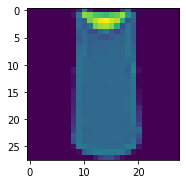

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
83001/83001 [==============================] - 3s 40us/step - loss: 0.6892 - acc: 0.7647: 
Epoch 2/20
83001/83001 [==============================] - 2s 27us/step - loss: 0.5074 - acc: 0.8041: 1s
Epoch 3/20
83001/83001 [==============================] - 2s 28us/step - loss: 0.4661 - acc: 0.8149: 1s - loss:  - ETA: 0s - loss: 0.4651 - acc:  - ETA: 0s - loss: 0.4669 - acc: 0.
Epoch 4/20
83001/83001 [==============================] - 3s 35us/step - loss: 0.4432 - acc: 0.8221: 2s - loss: 0.4394 - - ETA: 1s 
Epoch 5/20
83001/83001 [==============================] - 3s 34us/step - loss: 0.4247 - acc: 0.8285
Epoch 6/20
83001/83001 [==============================] - 3s 35us/step - loss: 0.4062 - acc: 0.8350: 1s 
Epoch 7/20
83001/83001 [==============================] - 5s 55us/step - loss: 0.3963 - acc: 0.8382
Epoch 8/20
83001/83001 [==============================] - 3s 39us/step - loss: 0.3816 - acc: 0.8471: 0s - loss: 0.3807 - acc
Epoch 9/20
83001/83001 [===========================

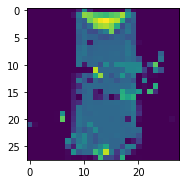


Test accuracy: 0.8837


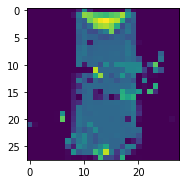

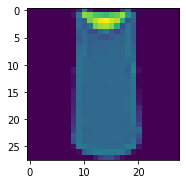

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
83001/83001 [==============================] - 3s 38us/step - loss: 0.6896 - acc: 0.7649A: 7s - loss: 1.2267 - acc:  - ETA: 3s - loss: 0.9605 - acc:  - ETA: 2s - loss:
Epoch 2/20
83001/83001 [==============================] - 2s 28us/step - loss: 0.4994 - acc: 0.8058: 2s - loss: 0.5315 - acc: 0. - ETA: 1s - - ETA: 0s - loss: 0.5003 - acc: 0.805
Epoch 3/20
83001/83001 [==============================] - 2s 28us/step - loss: 0.4624 - acc: 0.8166: 2s - loss: 0.4654 - ac - ETA: 1s - loss: 0.4788 - acc: 0.81 - ETA: 1s - loss: 0.4769 - acc:  - ETA: 1s - loss: 0.4715 - ac - ETA: 0s - loss: 0.4666 - ac
Epoch 4/20
83001/83001 [==============================] - 2s 28us/step - loss: 0.4378 - acc: 0.8239: 1s - loss: 0.4448 - acc: 0. - ETA: 0s - loss: 0.4422 
Epoch 5/20
83001/83001 [==============================] - 2s 26us/step - loss: 0.4203 - acc: 0.8302: 1s - loss: 0.4275 - acc:  - ETA: 0s - loss: 0.4238
Epoch 6/20
83001/83001 [==============================] - 2s 26us/step - loss: 0.

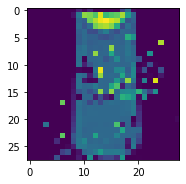


Test accuracy: 0.8806


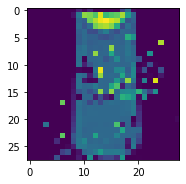

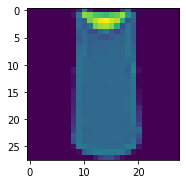

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
83001/83001 [==============================] - 3s 42us/step - loss: 0.6906 - acc: 0.7614: 5s - lo - ETA: 0s - loss: 0.7434 - ac - ETA: 0s - loss: 0.6990 - acc: 0.75
Epoch 2/20
83001/83001 [==============================] - 3s 31us/step - loss: 0.4993 - acc: 0.8066
Epoch 3/20
83001/83001 [==============================] - 3s 31us/step - loss: 0.4646 - acc: 0.8151: 1s - loss:  - ETA: 0s - loss: 0.4678 - acc: 0. - ETA: 0s - loss: 0.4661 - acc: 0.81 - ETA: 0s - loss: 0.4659 - acc: 0.81
Epoch 4/20
83001/83001 [==============================] - 3s 31us/step - loss: 0.4373 - acc: 0.8236
Epoch 5/20
83001/83001 [==============================] - 3s 31us/step - loss: 0.4186 - acc: 0.8301: 0s - loss: 0.4181 - acc: 0.829 - ETA: 0s - loss: 0.4177 - acc: 0.829 - ETA: 0s - loss: 0.4169 - a
Epoch 6/20
83001/83001 [==============================] - 3s 31us/step - loss: 0.4032 - acc: 0.8363
Epoch 7/20
83001/83001 [==============================] - 3s 31us/step - loss: 0.3871 - acc: 0.8430: 0s

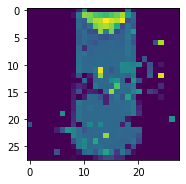


Test accuracy: 0.8686


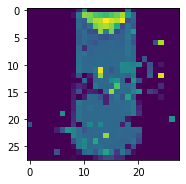

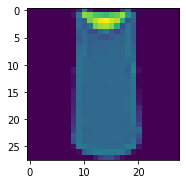

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
83001/83001 [==============================] - 3s 42us/step - loss: 0.7037 - acc: 0.7587: 0s - loss: 0.7044 - acc: 0.758
Epoch 2/20
83001/83001 [==============================] - 3s 31us/step - loss: 0.5023 - acc: 0.8048: 1s - loss: 0.
Epoch 3/20
83001/83001 [==============================] - 3s 31us/step - loss: 0.4643 - acc: 0.8159: 0s - loss: 0.4658 - acc: 0 - ETA: 0s - loss: 0.4646 - acc: 0.8 - ETA: 0s - loss: 0.4643 - acc: 0
Epoch 4/20
83001/83001 [==============================] - 3s 30us/step - loss: 0.4394 - acc: 0.8219: 1s - los
Epoch 5/20
83001/83001 [==============================] - 3s 31us/step - loss: 0.4213 - acc: 0.8292: 1s 
Epoch 6/20
83001/83001 [==============================] - 2s 29us/step - loss: 0.4039 - acc: 0.8354:
Epoch 7/20
83001/83001 [==============================] - 3s 31us/step - loss: 0.3878 - acc: 0.8423: 0s - loss: 0.3874 - acc
Epoch 8/20
83001/83001 [==============================] - 2s 30us/step - loss: 0.3761 - acc: 0.8474:
Epoch 9/20
83

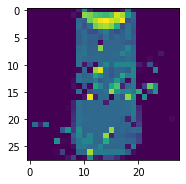


Test accuracy: 0.8799


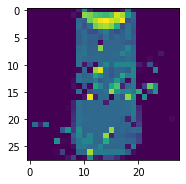

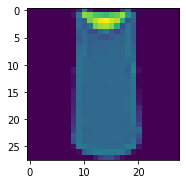

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
83001/83001 [==============================] - 3s 41us/step - loss: 0.7206 - acc: 0.7582
Epoch 2/20
83001/83001 [==============================] - 3s 30us/step - loss: 0.5225 - acc: 0.8022: 0s - loss: 0.5303 - acc: 0. - ETA: 0s - loss: 0.5275 
Epoch 3/20
83001/83001 [==============================] - 2s 29us/step - loss: 0.4807 - acc: 0.8126: 0s - loss: 0.4818 - acc: 0.812 - ETA: 0s - loss: 0.4816 - acc: 0.8
Epoch 4/20
83001/83001 [==============================] - 2s 29us/step - loss: 0.4598 - acc: 0.8173
Epoch 5/20
83001/83001 [==============================] - 2s 29us/step - loss: 0.4396 - acc: 0.8226: 2s - loss: 0.4469 - acc: 0.830
Epoch 6/20
83001/83001 [==============================] - 2s 29us/step - loss: 0.4249 - acc: 0.8281
Epoch 7/20
83001/83001 [==============================] - 2s 30us/step - loss: 0.4117 - acc: 0.8314: 1s
Epoch 8/20
83001/83001 [==============================] - 3s 30us/step - loss: 0.4000 - acc: 0.8377: 1s - loss: 0.4031 - acc: 0.837 - ETA: 1s

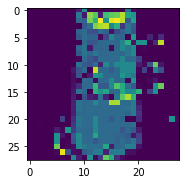


Test accuracy: 0.8838


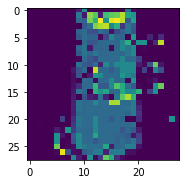

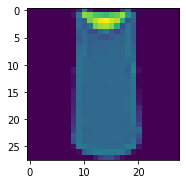

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
83001/83001 [==============================] - 4s 44us/step - loss: 0.7106 - acc: 0.7582: 7s - loss: 1.2200 - a - ETA: 3
Epoch 2/20
83001/83001 [==============================] - 3s 31us/step - loss: 0.5113 - acc: 0.8042: 2s - loss: 0.5449 - acc: 0.7
Epoch 3/20
83001/83001 [==============================] - 3s 32us/step - loss: 0.4710 - acc: 0.8144
Epoch 4/20
83001/83001 [==============================] - 3s 32us/step - loss: 0.4458 - acc: 0.8198
Epoch 5/20
83001/83001 [==============================] - 3s 32us/step - loss: 0.4264 - acc: 0.8258: 1s - loss: 0.4
Epoch 6/20
83001/83001 [==============================] - 3s 32us/step - loss: 0.4147 - acc: 0.8302: 1s - lo
Epoch 7/20
83001/83001 [==============================] - 3s 32us/step - loss: 0.4006 - acc: 0.8344
Epoch 8/20
83001/83001 [==============================] - 3s 31us/step - loss: 0.3882 - acc: 0.8396: 0s - loss: 0.3877 - acc
Epoch 9/20
83001/83001 [==============================] - 3s 32us/step - loss: 0.3767 - 

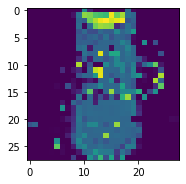


Test accuracy: 0.8769


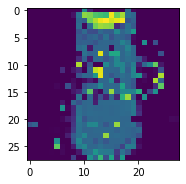

In [61]:
start = 2
size = 1
force = 5
d = 10
#attack(start, size, force, d)
accu_by_force = [0.0]*20
accu_by_force[0] = accu_by_force[1] = accu_by_force[2] = 0.0
img_by_force = [None]*20

for i in range(3, 20):
    accu_by_force[i]= attack(start,size, i, d)
    showImg(img_by_force[i])

[0.0, 0.0, 0.0, 0.8875, 0.8814, 0.8817, 0.8828, 0.8857, 0.8809, 0.8832, 0.8848, 0.8847, 0.8793, 0.8774, 0.8837, 0.8806, 0.8686, 0.8799, 0.8838, 0.8769]


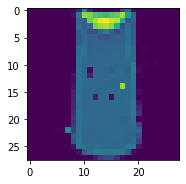

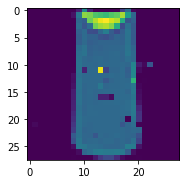

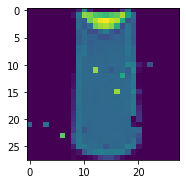

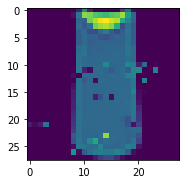

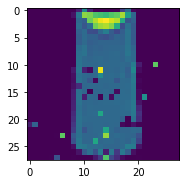

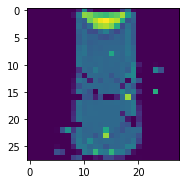

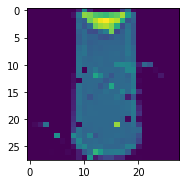

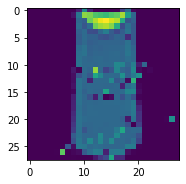

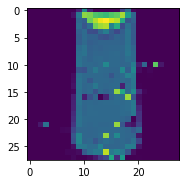

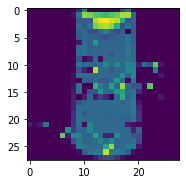

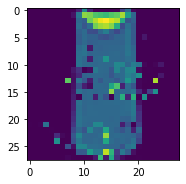

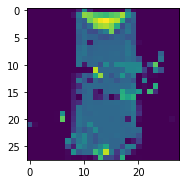

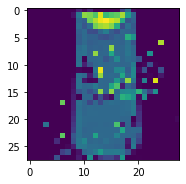

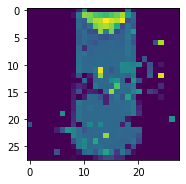

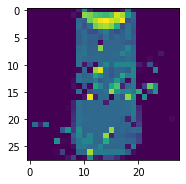

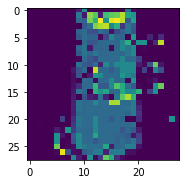

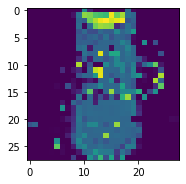

In [70]:
print(accu_by_force)
for i in range(3, 20):
    showImg(img_by_force[i])

In [87]:
from PIL import Image

import imageio
# imageio.imwrite('filename.jpg', img_by_force[3][0])
for i in range(3, 20):
    imageio.imwrite("force = "+str(i)+ " accuracy = "+ str(accu_by_force[i])+".jpg", img_by_force[i][0])
#     im = Image.fromarray(img_by_force[i])
#     im.save("force = "+str(i)+" accuracy = "+ str(accu_by_force[i]+".jpeg"))

d = 1


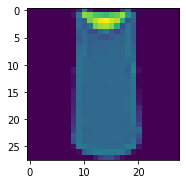

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
64182/64182 [==============================] - 3s 50us/step - loss: 0.6553 - acc: 0.7838: 1s - loss: 0.7510 - ac - ETA: 0s - loss: 0.6853 - acc:
Epoch 2/20
64182/64182 [==============================] - 2s 33us/step - loss: 0.4620 - acc: 0.8409: 0s - loss: 0.4675 - acc: 0.839 - ETA: 0s - loss: 0.4656 - acc: 0.8
Epoch 3/20
64182/64182 [==============================] - 2s 32us/step - loss: 0.4125 - acc: 0.8524: 1s 
Epoch 4/20
64182/64182 [==============================] - 2s 32us/step - loss: 0.3812 - acc: 0.8611
Epoch 5/20
64182/64182 [==============================] - 2s 31us/step - loss: 0.3635 - acc: 0.8664: 0s - loss: 0.3651 - acc: 0
Epoch 6/20
64182/64182 [==============================] - 2s 32us/step - loss: 0.3467 - acc: 0.8713
Epoch 7/20
64182/64182 [==============================] - 2s 31us/step - loss: 0.3343 - acc: 0.8762:
Epoch 8/20
64182/64182 [==============================] - 2s 32us/step - loss: 0.3214 - acc: 0.8783: 1s - loss: 0.3
Epoch 9/20
64182/64182 [==

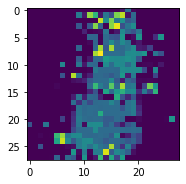


Test accuracy: 0.8745
d = 2


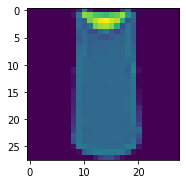

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
66273/66273 [==============================] - 3s 52us/step - loss: 0.6655 - acc: 0.7804: 8s - loss: 1.1796 - a - ETA: 2s - loss:  - ETA: 0s - loss: 0.6861 - acc: 0
Epoch 2/20
66273/66273 [==============================] - 2s 35us/step - loss: 0.4572 - acc: 0.8367
Epoch 3/20
66273/66273 [==============================] - 2s 36us/step - loss: 0.4101 - acc: 0.8500: 0s - loss: 0.4112 - acc: 0 - ETA: 0s - loss: 0.4105 - acc: 0
Epoch 4/20
66273/66273 [==============================] - 2s 33us/step - loss: 0.3836 - acc: 0.8571
Epoch 5/20
66273/66273 [==============================] - 2s 36us/step - loss: 0.3656 - acc: 0.8634: 0s - loss: 0.3654 - ac
Epoch 6/20
66273/66273 [==============================] - 3s 38us/step - loss: 0.3493 - acc: 0.8687
Epoch 7/20
66273/66273 [==============================] - 3s 49us/step - loss: 0.3363 - acc: 0.8740
Epoch 8/20
66273/66273 [==============================] - 3s 51us/step - loss: 0.3253 - acc: 0.8762
Epoch 9/20
66273/66273 [==============

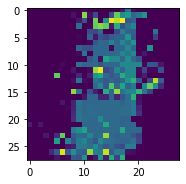


Test accuracy: 0.8821
d = 3


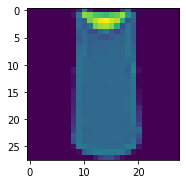

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
68364/68364 [==============================] - 3s 51us/step - loss: 0.6614 - acc: 0.7818
Epoch 2/20
68364/68364 [==============================] - 2s 33us/step - loss: 0.4599 - acc: 0.8342: 1s
Epoch 3/20
68364/68364 [==============================] - 2s 32us/step - loss: 0.4152 - acc: 0.8460
Epoch 4/20
68364/68364 [==============================] - 2s 32us/step - loss: 0.3866 - acc: 0.8542: 1s - loss: 0.
Epoch 5/20
68364/68364 [==============================] - 2s 32us/step - loss: 0.3682 - acc: 0.8605
Epoch 6/20
68364/68364 [==============================] - 2s 34us/step - loss: 0.3521 - acc: 0.8648
Epoch 7/20
68364/68364 [==============================] - 2s 33us/step - loss: 0.3393 - acc: 0.8709
Epoch 8/20
68364/68364 [==============================] - 2s 31us/step - loss: 0.3270 - acc: 0.8742: 0s - loss: 0.3280 -
Epoch 9/20
68364/68364 [==============================] - 2s 32us/step - loss: 0.3170 - acc: 0.8779
Epoch 10/20
68364/68364 [==============================] - 2

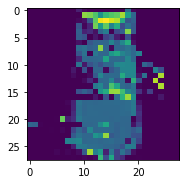


Test accuracy: 0.884
d = 4


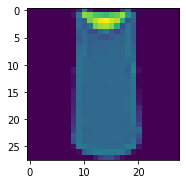

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
70455/70455 [==============================] - 4s 51us/step - loss: 0.6730 - acc: 0.7761: 2s - loss: 0
Epoch 2/20
70455/70455 [==============================] - 2s 34us/step - loss: 0.4652 - acc: 0.8297
Epoch 3/20
70455/70455 [==============================] - 2s 35us/step - loss: 0.4222 - acc: 0.8430
Epoch 4/20
70455/70455 [==============================] - 2s 34us/step - loss: 0.3934 - acc: 0.8498
Epoch 5/20
70455/70455 [==============================] - 2s 34us/step - loss: 0.3724 - acc: 0.8585: 1s - 
Epoch 6/20
70455/70455 [==============================] - 2s 33us/step - loss: 0.3558 - acc: 0.8627
Epoch 7/20
70455/70455 [==============================] - 2s 35us/step - loss: 0.3403 - acc: 0.8691
Epoch 8/20
70455/70455 [==============================] - 2s 33us/step - loss: 0.3294 - acc: 0.8721
Epoch 9/20
70455/70455 [==============================] - 2s 33us/step - loss: 0.3162 - acc: 0.8771: 2s  - ETA: 0s - loss: 0.3171 - acc
Epoch 10/20
70455/70455 [==================

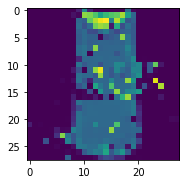


Test accuracy: 0.8844
d = 5


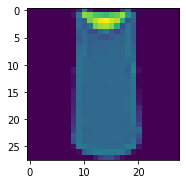

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
72546/72546 [==============================] - 4s 54us/step - loss: 0.6767 - acc: 0.7754: 6s - loss: 1.0331 - - ETA: 2s - loss: 0.8269 - acc: 0 - ETA: 1s - loss: 0
Epoch 2/20
72546/72546 [==============================] - 3s 42us/step - loss: 0.4589 - acc: 0.8300: 0s - loss: 0.4659 - acc: 0 - ETA: 0s - loss: 0.4633 - acc
Epoch 3/20
72546/72546 [==============================] - 2s 34us/step - loss: 0.4165 - acc: 0.8411: 2s - loss: 0.4031 - acc: 0 - ETA: 2s - l - ETA: 0s - loss: 0.4174 - ac
Epoch 4/20
72546/72546 [==============================] - 3s 36us/step - loss: 0.3902 - acc: 0.8493
Epoch 5/20
72546/72546 [==============================] - 3s 35us/step - loss: 0.3661 - acc: 0.8577
Epoch 6/20
72546/72546 [==============================] - 2s 33us/step - loss: 0.3509 - acc: 0.8630
Epoch 7/20
72546/72546 [==============================] - ETA: 0s - loss: 0.3395 - acc: 0.8674- ETA: 0s - loss: 0.3399 - acc: 0.8 - 2s 33us/step - loss: 0.3395 - acc: 0.8675
Epoch 8/20
72546/725

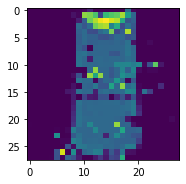


Test accuracy: 0.8836
d = 6


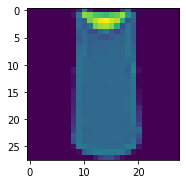

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
74637/74637 [==============================] - 4s 51us/step - loss: 0.6818 - acc: 0.7743: 0s - loss: 0.6829 - acc: 0.774
Epoch 2/20
74637/74637 [==============================] - 3s 35us/step - loss: 0.4681 - acc: 0.8238
Epoch 3/20
74637/74637 [==============================] - 3s 39us/step - loss: 0.4226 - acc: 0.8377: 0s - loss: 0.4239 -
Epoch 4/20
74637/74637 [==============================] - 3s 37us/step - loss: 0.4005 - acc: 0.8440
Epoch 5/20
74637/74637 [==============================] - 3s 38us/step - loss: 0.3790 - acc: 0.8534: 2 - ETA: 0s - loss: 0.3774 - acc: 0.85 - ETA: 0s - loss: 0.3785 - ac
Epoch 6/20
74637/74637 [==============================] - 3s 36us/step - loss: 0.3587 - acc: 0.8604: 0s - loss: 0.3628
Epoch 7/20
74637/74637 [==============================] - 3s 35us/step - loss: 0.3471 - acc: 0.8634: 0s - loss: 0.3471
Epoch 8/20
74637/74637 [==============================] - 3s 35us/step - loss: 0.3348 - acc: 0.8682: 2s - - ETA: 0s - loss: 0.3364 - a
Epoc

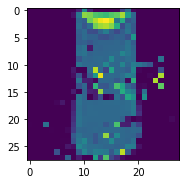


Test accuracy: 0.8744
d = 7


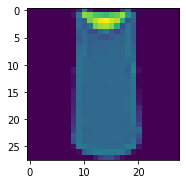

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
76728/76728 [==============================] - 4s 50us/step - loss: 0.6766 - acc: 0.7752: 2s - loss: 0.82 - ETA: 0s - loss: 0.7049 - acc: 
Epoch 2/20
76728/76728 [==============================] - 3s 40us/step - loss: 0.4629 - acc: 0.8235
Epoch 3/20
76728/76728 [==============================] - 3s 36us/step - loss: 0.4217 - acc: 0.8361
Epoch 4/20
76728/76728 [==============================] - 3s 37us/step - loss: 0.3946 - acc: 0.8449
Epoch 5/20
76728/76728 [==============================] - 3s 36us/step - loss: 0.3714 - acc: 0.8523: 0s - loss: 0.3724 - a
Epoch 6/20
76728/76728 [==============================] - 3s 37us/step - loss: 0.3544 - acc: 0.8591
Epoch 7/20
76728/76728 [==============================] - 3s 37us/step - loss: 0.3410 - acc: 0.8644
Epoch 8/20
76728/76728 [==============================] - 3s 40us/step - loss: 0.3249 - acc: 0.8707
Epoch 9/20
76728/76728 [==============================] - 3s 36us/step - loss: 0.3118 - acc: 0.8760: 0s - loss: 0.3112 - acc: 0

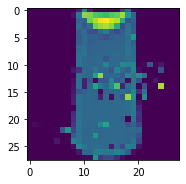


Test accuracy: 0.8781
d = 8


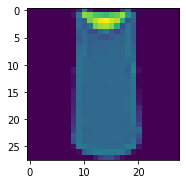

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
78819/78819 [==============================] - 5s 57us/step - loss: 0.6876 - acc: 0.7699
Epoch 2/20
78819/78819 [==============================] - 3s 40us/step - loss: 0.4678 - acc: 0.8207
Epoch 3/20
78819/78819 [==============================] - 3s 42us/step - loss: 0.4260 - acc: 0.8335: 0s - loss: 0.4288 - a
Epoch 4/20
78819/78819 [==============================] - 3s 41us/step - loss: 0.4016 - acc: 0.8421: 0s - loss: 0.40
Epoch 5/20
78819/78819 [==============================] - 3s 42us/step - loss: 0.3791 - acc: 0.8492
Epoch 6/20
78819/78819 [==============================] - 3s 34us/step - loss: 0.3583 - acc: 0.8564
Epoch 7/20
78819/78819 [==============================] - 3s 34us/step - loss: 0.3415 - acc: 0.8626: 0s - loss: 0.3414 - acc: 0.86
Epoch 8/20
78819/78819 [==============================] - 3s 35us/step - loss: 0.3264 - acc: 0.8702
Epoch 9/20
78819/78819 [==============================] - 3s 36us/step - loss: 0.3131 - acc: 0.8758
Epoch 10/20
78819/78819 [====

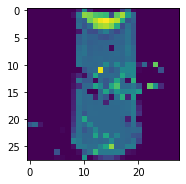


Test accuracy: 0.8841
d = 9


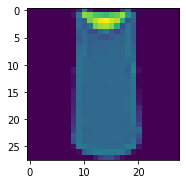

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
80910/80910 [==============================] - 4s 49us/step - loss: 0.6812 - acc: 0.7686: 1s - loss: 0.7487 
Epoch 2/20
80910/80910 [==============================] - 3s 38us/step - loss: 0.4667 - acc: 0.8205: 2s - loss: 0.4912 - ETA: 1s - loss: 0.4797 - acc: 0.815 - ETA: 1s - l
Epoch 3/20
80910/80910 [==============================] - 3s 34us/step - loss: 0.4232 - acc: 0.8335:  - ETA: 0s - loss: 0.4260 - acc: 0.
Epoch 4/20
80910/80910 [==============================] - 3s 34us/step - loss: 0.3961 - acc: 0.8423
Epoch 5/20
80910/80910 [==============================] - 3s 35us/step - loss: 0.3717 - acc: 0.8512
Epoch 6/20
80910/80910 [==============================] - 3s 35us/step - loss: 0.3516 - acc: 0.8583: 0s - loss: 0.
Epoch 7/20
80910/80910 [==============================] - 3s 33us/step - loss: 0.3343 - acc: 0.8668
Epoch 8/20
80910/80910 [==============================] - 3s 36us/step - loss: 0.3186 - acc: 0.8749
Epoch 9/20
80910/80910 [==============================] -

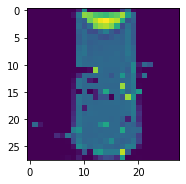


Test accuracy: 0.8775
d = 10


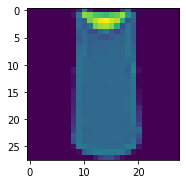

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
83001/83001 [==============================] - 4s 50us/step - loss: 0.6832 - acc: 0.7664: 1s - loss: 0.7321 -
Epoch 2/20
83001/83001 [==============================] - 3s 38us/step - loss: 0.4669 - acc: 0.8162: 2s - - ETA: 0s - loss: 0.4707
Epoch 3/20
83001/83001 [==============================] - 3s 41us/step - loss: 0.4232 - acc: 0.8312
Epoch 4/20
83001/83001 [==============================] - 4s 46us/step - loss: 0.3947 - acc: 0.8428
Epoch 5/20
83001/83001 [==============================] - 3s 37us/step - loss: 0.3708 - acc: 0.8495: 0s - loss: 0.3711 -
Epoch 6/20
83001/83001 [==============================] - 3s 34us/step - loss: 0.3509 - acc: 0.8580
Epoch 7/20
83001/83001 [==============================] - 3s 34us/step - loss: 0.3350 - acc: 0.8647: 1s - loss: 0.3371 -  - ETA: 0s - loss: 0.3362 - acc
Epoch 8/20
83001/83001 [==============================] - 3s 41us/step - loss: 0.3154 - acc: 0.8742
Epoch 9/20
83001/83001 [==============================] - 3s 36us/step - l

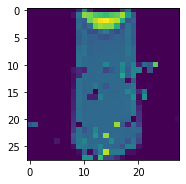


Test accuracy: 0.8798
d = 11


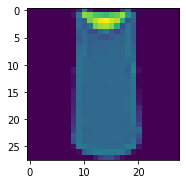

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
85092/85092 [==============================] - 4s 51us/step - loss: 0.6722 - acc: 0.7702: 3s - 
Epoch 2/20
85092/85092 [==============================] - 3s 34us/step - loss: 0.4651 - acc: 0.8168
Epoch 3/20
85092/85092 [==============================] - 3s 33us/step - loss: 0.4235 - acc: 0.8317: 0s - loss: 0.4245 - acc: 0.8
Epoch 4/20
85092/85092 [==============================] - 3s 35us/step - loss: 0.3936 - acc: 0.8416: 1s - loss:
Epoch 5/20
85092/85092 [==============================] - 3s 34us/step - loss: 0.3677 - acc: 0.8515: 2s - loss: 0. - ETA: 1s - lo
Epoch 6/20
85092/85092 [==============================] - 3s 34us/step - loss: 0.3482 - acc: 0.8599: 1s - l
Epoch 7/20
85092/85092 [==============================] - 3s 35us/step - loss: 0.3275 - acc: 0.8686:
Epoch 8/20
85092/85092 [==============================] - 3s 36us/step - loss: 0.3091 - acc: 0.8784
Epoch 9/20
85092/85092 [==============================] - 3s 35us/step - loss: 0.2914 - acc: 0.8881
Epoch 10/20


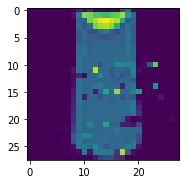


Test accuracy: 0.8775
d = 12


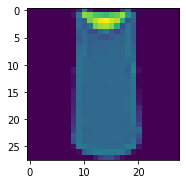

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
87183/87183 [==============================] - 5s 57us/step - loss: 0.6804 - acc: 0.7649
Epoch 2/20
87183/87183 [==============================] - 3s 37us/step - loss: 0.4658 - acc: 0.8162
Epoch 3/20
87183/87183 [==============================] - 3s 35us/step - loss: 0.4248 - acc: 0.8306
Epoch 4/20
87183/87183 [==============================] - 3s 37us/step - loss: 0.3942 - acc: 0.8413
Epoch 5/20
87183/87183 [==============================] - 3s 36us/step - loss: 0.3722 - acc: 0.8495
Epoch 6/20
87183/87183 [==============================] - 3s 37us/step - loss: 0.3539 - acc: 0.8564: 1s -
Epoch 7/20
87183/87183 [==============================] - 3s 35us/step - loss: 0.3313 - acc: 0.8675
Epoch 8/20
87183/87183 [==============================] - 3s 35us/step - loss: 0.3127 - acc: 0.8751
Epoch 9/20
87183/87183 [==============================] - 3s 39us/step - loss: 0.2931 - acc: 0.8868
Epoch 10/20
87183/87183 [==============================] - 3s 38us/step - loss: 0.2751 - acc: 

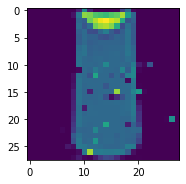


Test accuracy: 0.8793
d = 13


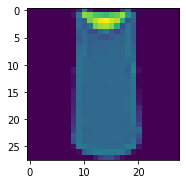

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
89274/89274 [==============================] - 5s 58us/step - loss: 0.6742 - acc: 0.7646: 3s - loss: 0.8286 - ac - ETA: 2s - loss: 0.7633 - acc: 0.743 - ETA: 2s - loss: 0.7569  - ETA: 0s - loss: 0.6986 - acc:
Epoch 2/20
89274/89274 [==============================] - 3s 37us/step - loss: 0.4701 - acc: 0.8128
Epoch 3/20
89274/89274 [==============================] - 3s 38us/step - loss: 0.4258 - acc: 0.8274: 0s - loss: 0.4266 - acc: 0.8
Epoch 4/20
89274/89274 [==============================] - 3s 37us/step - loss: 0.3962 - acc: 0.8380: 1s - loss: 0.4013 - acc: 0 - ETA: 1s - loss
Epoch 5/20
89274/89274 [==============================] - 3s 38us/step - loss: 0.3714 - acc: 0.8464: 3s - loss: 0.3725  - ETA: 2s - loss - ETA: 0s - loss: 0.
Epoch 6/20
89274/89274 [==============================] - 3s 37us/step - loss: 0.3485 - acc: 0.8574: 1s - los
Epoch 7/20
89274/89274 [==============================] - 3s 36us/step - loss: 0.3273 - acc: 0.8689
Epoch 8/20
89274/89274 [=============

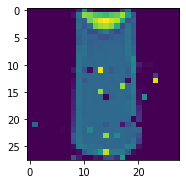


Test accuracy: 0.8813
d = 14


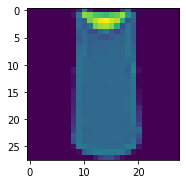

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
91365/91365 [==============================] - 5s 54us/step - loss: 0.6758 - acc: 0.7632: 7s - loss: 1 - ETA: 2s - loss: 0.7877 - acc - ETA: 1s - loss: 0.7456 - - ETA: 0s - loss: 0.6969 - acc
Epoch 2/20
91365/91365 [==============================] - 4s 40us/step - loss: 0.4669 - acc: 0.8127: 4s - loss: 0.4970 - acc: 0 - ETA: 3s - loss: 0.4893 - acc:  - ETA: 2s - loss: 0.4843 - ac - ETA: 2s - loss: 0.4808 - ac - ETA: 1s -
Epoch 3/20
91365/91365 [==============================] - 3s 36us/step - loss: 0.4255 - acc: 0.8271: 0s - loss: 0.4274 - acc: 0.826 - ETA: 0s - loss: 0.4266 - acc:
Epoch 4/20
91365/91365 [==============================] - 3s 35us/step - loss: 0.3945 - acc: 0.8383
Epoch 5/20
91365/91365 [==============================] - 3s 36us/step - loss: 0.3698 - acc: 0.8490
Epoch 6/20
91365/91365 [==============================] - 3s 35us/step - loss: 0.3462 - acc: 0.8592
Epoch 7/20
91365/91365 [==============================] - 3s 35us/step - loss: 0.3242 - acc: 0.8700


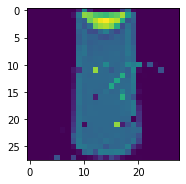


Test accuracy: 0.8805
d = 15


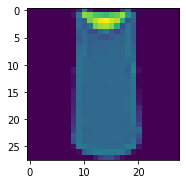

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
93456/93456 [==============================] - 5s 49us/step - loss: 0.6659 - acc: 0.7657: 0s - loss: 0.6832 - acc: 
Epoch 2/20
93456/93456 [==============================] - 3s 34us/step - loss: 0.4668 - acc: 0.8101: 0s - loss: 0.47
Epoch 3/20
93456/93456 [==============================] - 3s 34us/step - loss: 0.4267 - acc: 0.8250: 2s - loss: 0.4440 - acc: 0.8 - ETA: 2s - loss: 0.4319  -
Epoch 4/20
93456/93456 [==============================] - 3s 33us/step - loss: 0.3959 - acc: 0.8358
Epoch 5/20
93456/93456 [==============================] - 3s 33us/step - loss: 0.3683 - acc: 0.8474
Epoch 6/20
93456/93456 [==============================] - 3s 34us/step - loss: 0.3445 - acc: 0.8582: 0s - loss: 0.3449 - acc:
Epoch 7/20
93456/93456 [==============================] - 3s 34us/step - loss: 0.3219 - acc: 0.8712- ETA: 0s - loss: 0.3229 - ac
Epoch 8/20
93456/93456 [==============================] - 3s 34us/step - loss: 0.2996 - acc: 0.8838: 1s -
Epoch 9/20
93456/93456 [=============

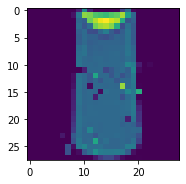


Test accuracy: 0.878
d = 16


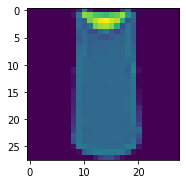

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
95547/95547 [==============================] - 5s 53us/step - loss: 0.6700 - acc: 0.7622: 1s - loss: 
Epoch 2/20
95547/95547 [==============================] - 3s 37us/step - loss: 0.4635 - acc: 0.8131: 2s  - ETA: 1s - los
Epoch 3/20
95547/95547 [==============================] - 4s 38us/step - loss: 0.4225 - acc: 0.8266: 1s - los
Epoch 4/20
95547/95547 [==============================] - 4s 38us/step - loss: 0.3904 - acc: 0.8384
Epoch 5/20
95547/95547 [==============================] - 4s 37us/step - loss: 0.3606 - acc: 0.8507: 1s - lo
Epoch 6/20
95547/95547 [==============================] - 4s 38us/step - loss: 0.3359 - acc: 0.8639: 1s - loss: 0.
Epoch 7/20
95547/95547 [==============================] - 4s 38us/step - loss: 0.3127 - acc: 0.8761
Epoch 8/20
95547/95547 [==============================] - 4s 38us/step - loss: 0.2885 - acc: 0.8895ETA: 0s - loss: 0.291
Epoch 9/20
95547/95547 [==============================] - 4s 39us/step - loss: 0.2648 - acc: 0.9012
Epoch 10/20

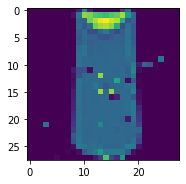


Test accuracy: 0.884
d = 17


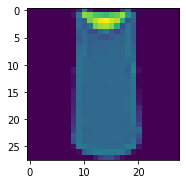

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
97638/97638 [==============================] - 5s 52us/step - loss: 0.6835 - acc: 0.7567: 0s - loss: 0.7205 -
Epoch 2/20
97638/97638 [==============================] - 4s 37us/step - loss: 0.4677 - acc: 0.8095: 2s - loss: 0. - ETA: 1s - loss: 0.4751 - acc - ETA: 0s - loss: 0.4714 - a
Epoch 3/20
97638/97638 [==============================] - 4s 40us/step - loss: 0.4238 - acc: 0.8252
Epoch 4/20
97638/97638 [==============================] - 4s 45us/step - loss: 0.3868 - acc: 0.8393
Epoch 5/20
97638/97638 [==============================] - 4s 39us/step - loss: 0.3566 - acc: 0.8522: 2s - loss: 0.3649 - - ETA: 1s - lo
Epoch 6/20
97638/97638 [==============================] - 4s 38us/step - loss: 0.3296 - acc: 0.8661: 3s - loss:
Epoch 7/20
97638/97638 [==============================] - 4s 40us/step - loss: 0.3016 - acc: 0.8821
Epoch 8/20
97638/97638 [==============================] - 4s 40us/step - loss: 0.2773 - acc: 0.8958: 0s - loss: 0.2
Epoch 9/20
97638/97638 [================

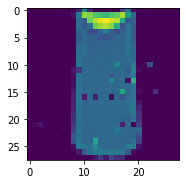


Test accuracy: 0.8788
d = 18


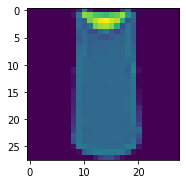

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
99729/99729 [==============================] - 5s 52us/step - loss: 0.6599 - acc: 0.7638: 0s - loss: 0.6822 - acc:  - ETA: 0s - loss: 0.6635 - acc: 0.76
Epoch 2/20
99729/99729 [==============================] - 4s 38us/step - loss: 0.4627 - acc: 0.8105: 1 - ETA: 0s - loss: 0.4636 - acc: 0.8
Epoch 3/20
99729/99729 [==============================] - 4s 39us/step - loss: 0.4172 - acc: 0.8255: 0s - loss: 0.4181 - acc: 0
Epoch 4/20
99729/99729 [==============================] - 4s 38us/step - loss: 0.3828 - acc: 0.8408:  - ETA: 1s - loss: 0.3843 - acc - ETA: 1s - l
Epoch 5/20
99729/99729 [==============================] - 4s 39us/step - loss: 0.3523 - acc: 0.8540
Epoch 6/20
99729/99729 [==============================] - 4s 35us/step - loss: 0.3219 - acc: 0.8703
Epoch 7/20
99729/99729 [==============================] - 4s 37us/step - loss: 0.2953 - acc: 0.8863: 1s - loss: 0.3009 - acc: 0. - ETA: 1s - loss: 0.2987 -  - ETA: 0s - loss: 0.2965 - 
Epoch 8/20
99729/99729 [=============

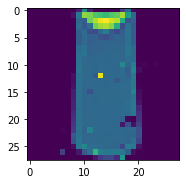


Test accuracy: 0.8844
d = 19


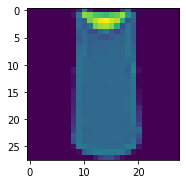

C:\Users\tony\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Epoch 1/20
101820/101820 [==============================] - 6s 56us/step - loss: 0.6529 - acc: 0.7633
Epoch 2/20
101820/101820 [==============================] - 4s 39us/step - loss: 0.4591 - acc: 0.8117: 1s - loss: 0.4709 - - ETA: 1s - loss: 0.4656 - ETA: 0s - loss: 0.4608 - acc: 
Epoch 3/20
101820/101820 [==============================] - 4s 40us/step - loss: 0.4087 - acc: 0.8298: 2 - ETA: 0s - loss: 0.4087 - acc: 0.8
Epoch 4/20
101820/101820 [==============================] - 4s 39us/step - loss: 0.3728 - acc: 0.8445
Epoch 5/20
101820/101820 [==============================] - 4s 40us/step - loss: 0.3394 - acc: 0.8605: 0s - loss: 0.3415 -
Epoch 6/20
101820/101820 [==============================] - 4s 41us/step - loss: 0.3109 - acc: 0.8774: 4s - 
Epoch 7/20
101820/101820 [==============================] - 4s 36us/step - loss: 0.2823 - acc: 0.8934: 0s - loss: 0.2832 - acc
Epoch 8/20
101820/101820 [==============================] - 4s 42us/step - loss: 0.2586 - acc: 0.9052: 3s - los - E

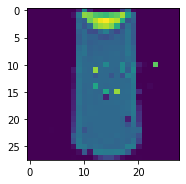


Test accuracy: 0.8781


In [105]:
force = 10
accu_by_d = [0.0]*20
img_by_d = [None]*20
for i in range(1, 20):
    print("d = "+str(i))
    accu_by_d[i]= attack(start,size, force, i)
    

[0.0, 0.8745, 0.8821, 0.884, 0.8844, 0.8836, 0.8744, 0.8781, 0.8841, 0.8775, 0.8798, 0.8775, 0.8793, 0.8813, 0.8805, 0.878, 0.884, 0.8788, 0.8844, 0.8781]


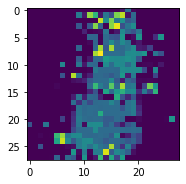

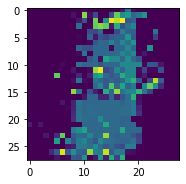

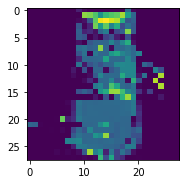

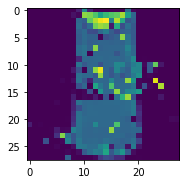

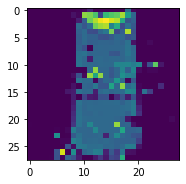

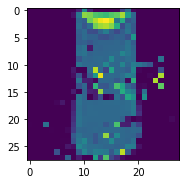

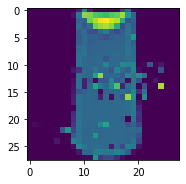

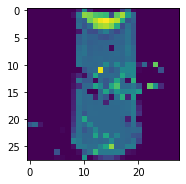

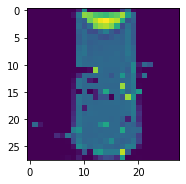

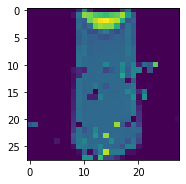

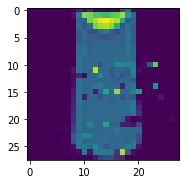

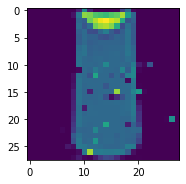

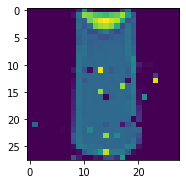

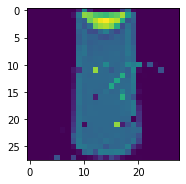

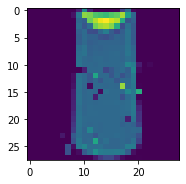

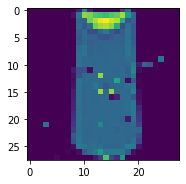

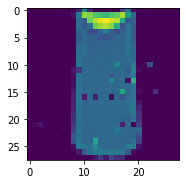

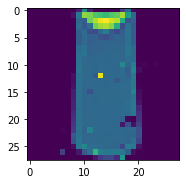

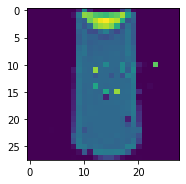

In [109]:
print(accu_by_d)
for i in range(1, 20):
    showImg(img_by_d[i])
    imageio.imwrite("d = "+str(i)+ " accuracy = "+ str(accu_by_d[i])+".jpg", img_by_d[i][0])